### Libraries

In [111]:
import pandas as pd
import numpy as np
from scipy.io import arff
import seaborn as sns
import matplotlib.pyplot as plt
import openml
#our neural network
from neuralnetwork import Network,FCLayer,ActivationLayer,sigmoid,sigmoid_prime,tanh,tanh_prime,categorical_cross_entropy,categorical_cross_entropy_prime,mse,mse_prime,binary_cross_entropy,binary_cross_entropy_prime,relu,relu_prime
import time
#sklearn
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.model_selection import train_test_split 
from sklearn.metrics import recall_score,accuracy_score,confusion_matrix, ConfusionMatrixDisplay, precision_score, make_scorer
from sklearn.model_selection import KFold
# from sklearn.model_selection import GridSearchCV,KFold,cross_val_score
import itertools
from imblearn.over_sampling import RandomOverSampler

from neuralnetwork import Network,FCLayer,ActivationLayer
from neuralnetwork import sigmoid,sigmoid_prime,tanh,tanh_prime,categorical_cross_entropy,categorical_cross_entropy_prime,mse,mse_prime,softmax,softmax_prime


### Data

In [166]:
#directly downloading from openml
dataset = openml.datasets.get_dataset(1461)
X, y, categorical_indicator, attribute_names = dataset.get_data(
    dataset_format="dataframe", target=dataset.default_target_attribute)

In [167]:
df_bank = pd.DataFrame(X, columns=attribute_names)
df_bank["class"] = y

In [168]:
# rename columns
column_names_bank = ['age', 'job', 'marital', 'education', 'default',
                     'balance', 'housing', 'loan', 'contact', 'day',
                     'month', 'duration', 'campaign', 'pdays',
                     'previous', 'poutcome', 'class']
df_bank.columns = column_names_bank

In [169]:
df_bank.head(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,class
0,58,management,married,tertiary,no,2143.0,yes,no,unknown,5,may,261.0,1,-1.0,0.0,unknown,1
1,44,technician,single,secondary,no,29.0,yes,no,unknown,5,may,151.0,1,-1.0,0.0,unknown,1
2,33,entrepreneur,married,secondary,no,2.0,yes,yes,unknown,5,may,76.0,1,-1.0,0.0,unknown,1
3,47,blue-collar,married,unknown,no,1506.0,yes,no,unknown,5,may,92.0,1,-1.0,0.0,unknown,1
4,33,unknown,single,unknown,no,1.0,no,no,unknown,5,may,198.0,1,-1.0,0.0,unknown,1


### Preparing the data

In [170]:

#some jobs look like can be combined together into same category
df_bank['job'] = df_bank['job'].replace(['services','housemaid'], 'pink-collar')
df_bank['job'] = df_bank['job'].replace(['admin','management'], 'blue-collar')
df_bank['job'] = df_bank['job'].replace(['student','unemployed','retired'], 'other')

#dropping this column since it does not bring much value to our analysis
df_bank.drop('contact', axis=1, inplace=True)

#dropping these columns since they do not bring much value to our analysis
df_bank.drop('month', axis=1, inplace=True)
df_bank.drop('day', axis=1, inplace=True)

# Replacing 'other' with unknown since for both of them we do not have valuable information
df_bank['poutcome'] = df_bank['poutcome'].replace('other', 'unknown')


In [171]:
X = df_bank.drop(['class'], axis=1)[['job','marital','education','default','housing','loan','poutcome','age','balance','duration','pdays','previous','balance']]
Y = df_bank['class']

In [172]:
cat_cols = ['job','marital','education','default','housing','loan','poutcome']

In [173]:
from sklearn.preprocessing import LabelEncoder

# Perform integer encoding
label_encoder = LabelEncoder()
for col in cat_cols:
    X[col] = label_encoder.fit_transform(X[col])
print(X)
X = X.to_numpy()
print(X)

encoder = OneHotEncoder(sparse = False)
y_reshaped = Y.to_numpy().reshape(-1,1)
Y = encoder.fit_transform(y_reshaped)

       job  marital  education  default  housing  loan  poutcome  age  \
0        1        1          2        0        1     0         2   58   
1        6        2          1        0        1     0         2   44   
2        2        1          1        0        1     1         2   33   
3        1        1          3        0        1     0         2   47   
4        7        2          3        0        0     0         2   33   
...    ...      ...        ...      ...      ...   ...       ...  ...   
45206    6        1          2        0        0     0         2   51   
45207    3        0          0        0        0     0         2   71   
45208    3        1          1        0        0     0         1   72   
45209    1        1          1        0        0     0         2   57   
45210    2        1          1        0        0     0         2   37   

       balance  duration  pdays  previous  balance  
0       2143.0     261.0   -1.0       0.0   2143.0  
1         29.0   

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [174]:
for i in X[0]:
    print(i)

1.0
1.0
2.0
0.0
1.0
0.0
2.0
58.0
2143.0
261.0
-1.0
0.0
2143.0


In [175]:
len(cat_cols)

7

In [176]:
#splitting into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1234)

#splitting into train and validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1,random_state = 1234)


In [177]:
for i in X_train[0]:
    print(i)

0.0
2.0
1.0
0.0
1.0
0.0
2.0
33.0
1437.0
641.0
-1.0
0.0
1437.0


In [178]:
scaler = StandardScaler()
X_train[:,len(cat_cols)-1:] = scaler.fit_transform(X_train[:,len(cat_cols)-1:])
X_test[:,len(cat_cols)-1:]  = scaler.transform(X_test[:,len(cat_cols)-1:])
X_val[:,len(cat_cols)-1:]  = scaler.transform(X_val[:,len(cat_cols)-1:])

Scaling the data

Since some of the features are categorical, we will apply scaling to the numeric columns only

In [181]:
for i in X_train[0]:
    print(i)

0.0
2.0
1.0
0.0
1.0
0.0
0.3956854385505649
-0.7435220126601306
0.028824600696943693
1.476071012207698
-0.41327724247777153
-0.30226542912459375
0.028824600696943693


### Our Neural Network Implementation

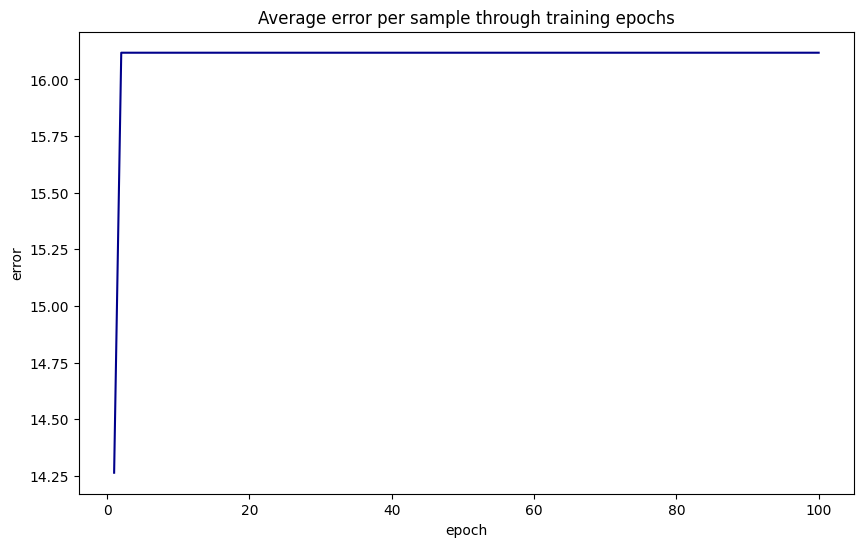

In [180]:
seed = 1234
# network with 3 layers
seed = 1234
# network with 3 layers
net = Network()
net.add(FCLayer(13, 8,seed =  seed))
net.add(FCLayer(8, 8,seed =  seed))    
net.add(FCLayer(8, 2,seed =  seed))  
net.add(ActivationLayer(tanh, tanh_prime))
# train

net.use(binary_cross_entropy, binary_cross_entropy_prime)

err_vect = net.fit_batch(X_train, y_train, epochs=100, learning_rate=0.1)
net.plot_error_curve(err_vect)

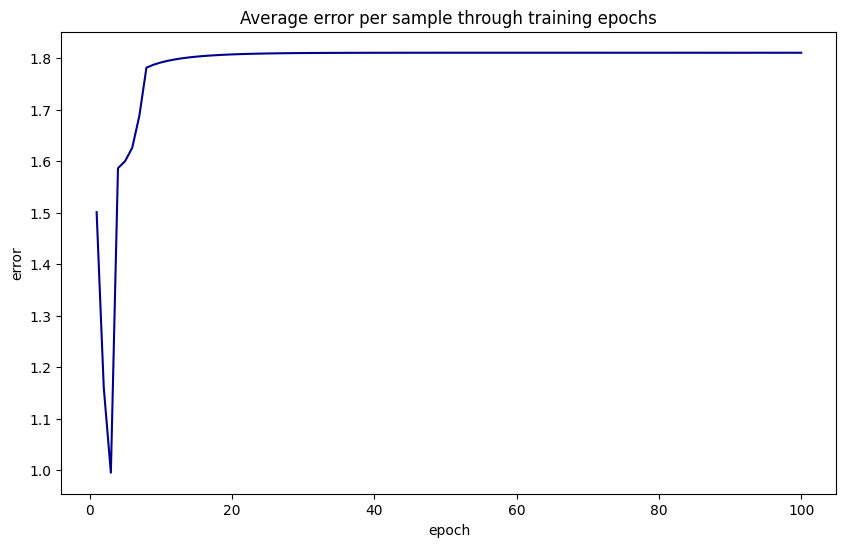

In [182]:
seed = 1234
# network with 3 layers
seed = 1234
# network with 3 layers
net = Network()
net.add(FCLayer(13, 8,seed =  seed))
net.add(FCLayer(8, 8,seed =  seed))    
net.add(FCLayer(8, 2,seed =  seed))  
net.add(ActivationLayer(sigmoid, sigmoid_prime))
# train

net.use(binary_cross_entropy, binary_cross_entropy_prime)

err_vect = net.fit_batch(X_train, y_train, epochs=100, learning_rate=0.1)
net.plot_error_curve(err_vect)

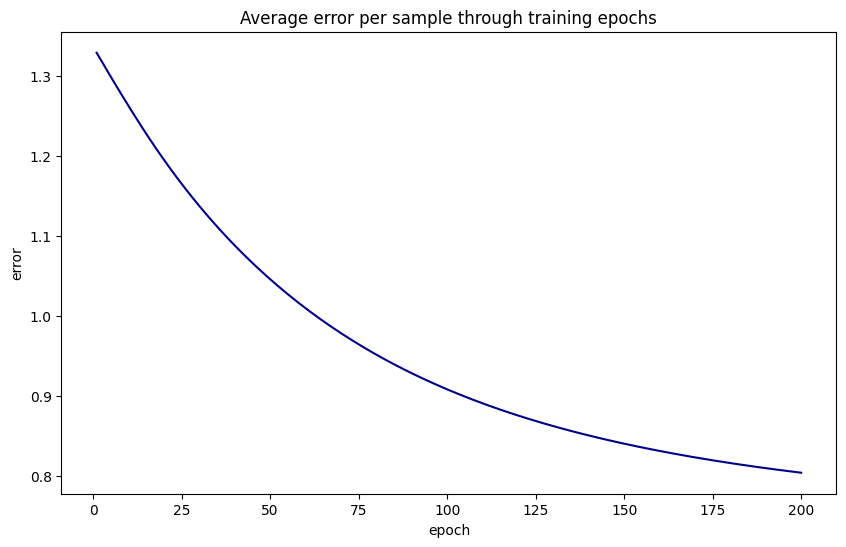

In [183]:
seed = 1234
# network with 3 layers
seed = 1234
# network with 3 layers
net = Network()
net.add(FCLayer(13, 8,seed =  seed))
net.add(ActivationLayer(tanh, tanh_prime))
net.add(FCLayer(8, 8,seed =  seed))    
net.add(ActivationLayer(tanh, tanh_prime))
net.add(FCLayer(8, 2,seed =  seed))  
net.add(ActivationLayer(sigmoid, sigmoid_prime))
# train

net.use(binary_cross_entropy, binary_cross_entropy_prime)

err_vect = net.fit_batch(X_train, y_train, epochs=200, learning_rate=0.01)
net.plot_error_curve(err_vect)